# Breastfeeding survey analysis

This notebook analyses the survey responses to Jessica Barton's breastfeeding questionnaire.

Items

  - Summarize population (number screened, criteria, >= 18 years old, Mirena usage positive or negative)
  - Within population, summarize demographic factors (age, race, ethnicity, education, income, marital status), exposure, covariates, and outcome
  - Exposure: Mirena usage [= hormonal IUD]
  - Covariates:
    - Hormonal issues (how defined?)
    - Difficulty conceiving
    - Age of baby at start of birth control (Mirena?)
    - Age of mother
    - Mother overweight
  - Outcome: milk supply went down
  
  - Describe unadjusted "rate" of outcome for each birth control type
  - Describe "rate" adjusted for covariates for each birth control type?

## Setup and read in the data

In [1]:
import sqlite3
import numpy as np
import pandas as pd
from pandas.io.sql import read_sql_query

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn = sqlite3.connect('../data/analysis.sqlite3')
curs = conn.cursor()
curs.execute("attach database '../data/codes.sqlite3' as codes;")

population_query = '''
    select RespondentId, sex, age_yc, bf_status, age_mother, AP, AP_reason
    from survey
'''

population = read_sql_query(population_query, conn)
survey = read_sql_query('select * from survey where AP = 1', conn)

def table(column, connection=conn):
    '''Query a database to summarize a coded variable using its code table'''
    query = '''
        select c.Code, c.Description, count(*) as n
        from survey as s left join codes.{} as c on s.{} = c.Code
        where s.AP = 1
        group by c.Code, c.Description
        order by 1
    '''.format(column, column, column)
    
    t = read_sql_query(query, connection)
    n = t.n[t.Code.notnull()]
    t['%'] = np.round(n/n.sum() * 1000)/10
    
    return t

In [3]:
population.head()

,RespondentID,sex,age_yc,bf_status,age_mother,AP,AP_reason
0,2503542169,2,2.0,NaN,NaN,0,2
1,2503602344,2,1.0,1.0,29.0,1,0
2,2503604232,2,1.0,1.0,32.0,1,0
3,2503605645,2,1.0,1.0,32.0,1,0
4,2503606246,2,1.0,1.0,32.0,1,0


## Summarize enrollment

In [4]:
read_sql_query('''
    select 0 as Code, 'Total screened' as Description, count(*) as n
    from survey
        union all
    select a.Code, a.Description, count(*) as n
    from codes.AP_reason as a
        inner join survey as s
            on a.Code = s.AP_reason
    group by a.Code, a.Description
        union all
    select 10 as Code, 'Total included in analysis population', count(*) as n
    from survey
    where AP = 1
    order by 1
''', conn).set_index(['Code', 'Description'])

,,n
Code,Description,
0,Total screened,4688
1,Respondent was male,8
2,Youngest child older than 18 months,391
3,Youngest child weaned more than 18 months ago,7
4,Youngest child never breastfed,10
5,Respondent not confirmed 18 years or older,540
10,Total included in analysis population,3732


In [5]:
# Check total
4688 - (8 + 391 + 7 + 10 + 540)

3732

Based on the above, 4,688 attempted with survey, with 8 being excluded for being male, 391 for not having a young enough child, 7 for having weaned too long ago, 10 for never having breastfed their youngest child, and 540 for being too young (or not having clean enough data to show how old they were). A total of 3,732 are therefore eligible to be included in the main analysis.

Parenthetically, the age restriction is a bit conservative. As we only collected birth year and all of the surveys were completed in 2013, age was computed as the smallest possible age (that is, as age before birthday in 2013).

### Demographics and other characteristics

In [6]:
continuous = ['age_mother', 'height', 'weight', 'bmi', 'menarche', 'BC_age']
pd.concat([survey[[s]].dropna().describe().unstack().unstack() for s in continuous])

,count,mean,std,min,25%,50%,75%,max
age_mother,3732.0,30.379957,4.411652,18.000000,28.000000,30.000000,33.000000,48.000000
height,3728.0,65.132511,2.774048,58.000000,63.000000,65.000000,67.000000,76.000000
weight,3691.0,160.642373,38.928696,80.000000,132.000000,152.000000,180.000000,370.000000
bmi,3689.0,26.599141,6.139525,11.477551,22.148708,25.237773,29.911562,57.919123
menarche,3710.0,12.519137,1.451484,8.000000,12.000000,12.000000,13.000000,21.000000
BC_age,3182.0,18.241672,3.149685,11.000000,16.000000,18.000000,20.000000,35.000000


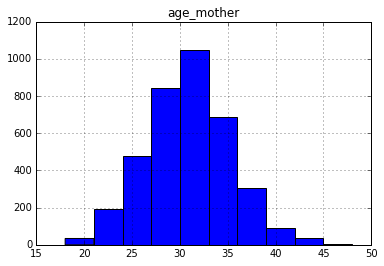

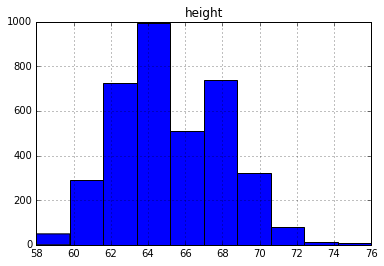

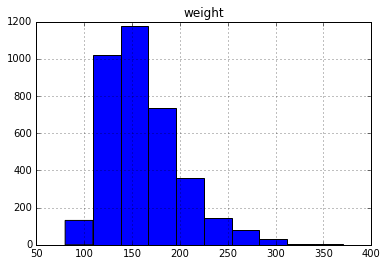

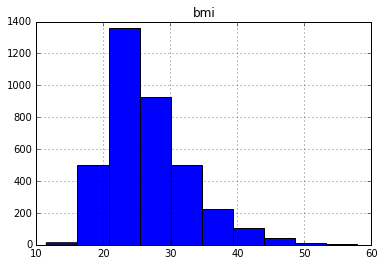

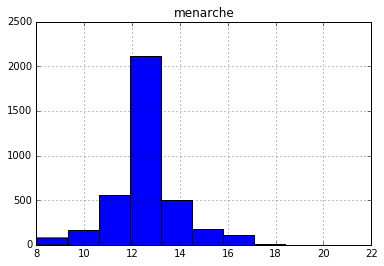

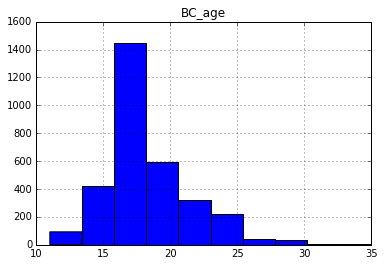

In [7]:
for s in continuous:
    survey[[s]].hist()

In [8]:
categoricals = ['race', 'ethnicity', 'education', 'income', 'marital_status']
tables = [table(c) for c in categoricals]
pd.concat(tables, keys=categoricals)

Code                                   Description     n  \
race           0    NaN                                          None    66   
               1    1.0                                         White  3421   
               2    2.0                     Black or African-American    44   
               3    3.0             American Indian or Alaskan Native    22   
               4    4.0                                         Asian    44   
               5    5.0     Native Hawaiian or other Pacific Islander     8   
               6    6.0                           From multiple races   127   
ethnicity      0    NaN                                          None    89   
               1    1.0                            Hispanic or Latino   208   
               2    2.0                        Not Hispanic or Latino  3435   
education      0    NaN                                          None     5   
               1    1.0                  Less than high school degree    25   
               2    2.0  High school degree or equivalent (e.g., GED)   178   
               3    3.0                    Some college but no degree   697   
               4    4.0                              Associate degree   370   
               5    5.0                               Bachelor degree  1454   
               6    6.0                               Graduate degree  1003   
income         0    NaN                                          None   146   
               1    1.0                            Less than \$10,000    59   
               2    2.0                           \$10,000 - \$19,000   101   
               3    3.0                           \$20,000 - \$29,000   220   
               4    4.0                           \$30,000 - \$39,000   314   
               5    5.0                           \$40,000 - \$49,000   303   
               6    6.0                           \$50,000 - \$59,000   325   
               7    7.0                           \$60,000 - \$69,000   329   
               8    8.0                           \$70,000 - \$79,000   363   
               9    9.0                           \$80,000 - \$89,000   312   
               10  10.0                           \$90,000 - \$99,000   293   
               11  11.0                         \$100,000 - \$149,000   659   
               12  12.0                             \$150,000 or More   308   
marital_status 0    NaN                                          None     7   
               1    1.0                                       Married  3436   
               2    2.0                                       Widowed     6   
               3    3.0                                      Divorced    36   
               4    4.0                                     Separated    18   
               5    5.0                                 Never married   229   

                      %  
race           0    NaN  
               1   93.3  
               2    1.2  
               3    0.6  
               4    1.2  
               5    0.2  
               6    3.5  
ethnicity      0    NaN  
               1    5.7  
               2   94.3  
education      0    NaN  
               1    0.7  
               2    4.8  
               3   18.7  
               4    9.9  
               5   39.0  
               6   26.9  
income         0    NaN  
               1    1.6  
               2    2.8  
               3    6.1  
               4    8.8  
               5    8.4  
               6    9.1  
               7    9.2  
               8   10.1  
               9    8.7  
               10   8.2  
               11  18.4  
               12   8.6  
marital_status 0    NaN  
               1   92.2  
               2    0.2  
               3    1.0  
               4    0.5  
               5    6.1

### Quick summary of body mass index within the population

This is a little different from the analysis that Frances already ran. Not sure why, since we're looking at the same data...

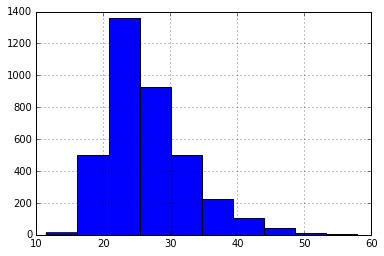

In [9]:
survey.bmi.hist()

In [10]:
table('bmi_category')

,Code,Description,n,%
0,NaN,None,43,NaN
1,1.0,Underweight,111,3.0
2,2.0,Normal weight,1659,45.0
3,3.0,Overweight,1020,27.6
4,4.0,Obese,899,24.4
